In [10]:
import os
from os import listdir
from os.path import isfile, join
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from preprocessor import get_multiclass_paths

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [104]:
def get_train_loader(data, loader_rule):
    if loader_rule == 'WEIGHTED_BINARY_SAMPLER':
        weights = Y.type('torch.FloatTensor')*7.48 + 1
        sampler = data_utils.sampler.WeightedRandomSampler(weights,len(weights),replacement=True)
        train_loader = data_utils.DataLoader(data, batch_size=64, sampler=sampler, num_workers=10)
    else:
        train_loader = data_utils.DataLoader(data, batch_size=64, shuffle=True)
    return train_loader

In [ ]:
def train_model(model, criterion, optimizer, loader_rule=None, scheduler=None, num_epochs=25,\
                chunks=9, data_dir='data'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        if (epoch+1)%10==0:
            torch.save(model, 'models/1_71_{}.pt'.format(str(epoch+1)))

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for chunk in range(chunks):
            X, Y = torch.load(data_dir + '/images-' + str(chunk) + '.pt'),\
                   torch.load(data_dir + '/labels-' + str(chunk) + '.pt')
            training_data = data_utils.TensorDataset(X, Y)
            train_loader = get_train_loader(training_data, loader_rule)
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # track history
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if scheduler:
                scheduler.step()
        train_loss = running_loss
        train_acc = running_corrects.double() / (chunks*2169)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(
            train_loss, train_acc))
        
        model.eval()
        val_loss, val_acc = test_model(model, criterion, data_dir, get_outputs=False)
        
        # deep copy the model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        train_accs.append(float(train_acc))
        val_accs.append(float(val_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, val_accs

In [106]:
def test_model(model, criterion, data_dir, get_outputs=True):
    model.eval()
    X, Y = torch.load(data_dir + '/images-9.pt'),\
           torch.load(data_dir + '/labels-9.pt')
    running_loss = 0.0
    running_corrects = 0
    train = data_utils.TensorDataset(X, Y)
    
    all_outputs = []
    all_labels = []
    
    train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=True)
    for inputs, labels in train_loader:
        with torch.set_grad_enabled(False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        if get_outputs:
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())
            
    loss = running_loss
    acc = running_corrects.double() / (len(Y))

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(
        loss, acc))
    
    if get_outputs:
        all_outputs = torch.cat((*all_outputs,))
        all_labels = torch.cat((*all_labels,))
        return all_outputs, all_labels
    
    return loss, acc

In [43]:
def summarize(all_outputs, all_labels, name):
    ''' Display the confusion matrix, ROC AUC score, and call to a function to 
        display ROC and precision-recall curves.
    '''
    _, all_preds = torch.max(all_outputs, 1)
    preds = all_preds.detach().numpy()
    labels = all_labels.detach().numpy()
    acc = accuracy_score(labels, preds)
    tn, fp, fn, tp = (confusion_matrix(labels, preds)/len(all_labels)).ravel()
    f1 = f1_score(labels, preds)
    
    print('Acc: {:.4f}'.format(acc))
    print("True negatives: " + str(tn))
    print("False positives: " + str(fp))
    print("False negatives: " + str(fn))
    print("True positives: " + str(tp))
    print('F1 score: {:.4f}'.format(f1))
    
    get_curves(all_outputs, all_labels, name)
    

In [39]:
def get_curves(all_outputs, all_labels, name):
    ''' Take torch tensors of all model outputs, all model labels
        and display an roc curve and a precision recall curve.
    '''
    sm = nn.Softmax(dim=1)
    roc_preds = sm(all_outputs).detach().numpy()[:,1]
    roc_labels = all_labels.detach().numpy()
    
    auc = roc_auc_score(roc_labels, roc_preds)
    print('Area under ROC curve: {:.4f}'.format(auc))
    
    ap = average_precision_score(roc_labels, roc_preds)
    print('Average precision score: {:.4f}'.format(ap))
    
    fpr, tpr, thresholds = roc_curve(roc_labels, roc_preds)
    precision, recall, thresholds = precision_recall_curve(roc_labels, roc_preds)
    
    plt.subplots(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=name)
    plt.plot(np.asarray([0.0, 1.0]), np.asarray([0.1, 1.0]), linestyle='dotted', label='random model')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")
    plt.legend(loc='upper right')
    
    plt.subplot(1,2,2)
    plt.plot(precision, recall, label=name)
    plt.plot(np.asarray([0.1, 1.0]), np.asarray([0.1, 0.1]), linestyle='dotted', label='random model')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision/recall curve')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Modeling
Models are stored in the `models/` directory in the following format: `{ID}-{weight}-{score}.pt`. `ID` is given as `p-q` for model number `p.q`. The `{weight}` is the weight assigned to the positive class in the loss function to correct for the class imbalance. The `{score}` is the test accuracy on the un-thresholded network - that is, with the network simply predicting the class with the highest activation.

Due to the substantial class imbalance, a random classifier which predicted the negative class would have an accuracy of roughly $90%$, so this is not a robust metric. Hence, we have constructed the `summarize` function to display a model's ROC Curve, its Precision-recall curve, and its confusion matrix.

# 1_1 VGG-19
Here we replace the fully-connected layer of a VGG-19 with two output neurons for binary classification. To combat the class imbalance, we penalize misclassifications in the positive class with a weighting of $6$.

In [161]:
model = models.vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Linear(in_features, 2)
model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,6]).to(device))
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/paperspace/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:09<00:00, 58666362.22it/s]


In [164]:
train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25, chunks=9)

Epoch 1/25
----------
train Loss: 32.4838 Acc: 0.7391
val Loss: 13.1053 Acc: 0.8092
Epoch 2/25
----------
train Loss: 22.9942 Acc: 0.7616
val Loss: 10.3367 Acc: 0.7715
Epoch 3/25
----------
train Loss: 20.8787 Acc: 0.7721
val Loss: 9.9886 Acc: 0.7766
Epoch 4/25
----------
train Loss: 20.3021 Acc: 0.7753
val Loss: 10.0739 Acc: 0.7748
Epoch 5/25
----------
train Loss: 20.1357 Acc: 0.7748
val Loss: 10.1113 Acc: 0.7748
Epoch 6/25
----------
train Loss: 20.2731 Acc: 0.7748
val Loss: 10.0488 Acc: 0.7748
Epoch 7/25
----------
train Loss: 19.9641 Acc: 0.7764
val Loss: 10.0176 Acc: 0.7748
Epoch 8/25
----------
train Loss: 20.0410 Acc: 0.7724
val Loss: 10.0376 Acc: 0.7748
Epoch 9/25
----------
train Loss: 20.3059 Acc: 0.7763
val Loss: 10.0799 Acc: 0.7748
Epoch 10/25
----------
train Loss: 20.4179 Acc: 0.7726
val Loss: 10.0571 Acc: 0.7748
Epoch 11/25
----------
train Loss: 20.5737 Acc: 0.7730
val Loss: 10.0797 Acc: 0.7748
Epoch 12/25
----------
train Loss: 19.1890 Acc: 0.7780
val Loss: 10.0645 Ac

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

Test Loss: 27230.3568 Acc: 0.8195
True negatives: 1622
False positives: 333
False negatives: 59
True positives: 158
Area under ROC curve: 0.8421558805850531


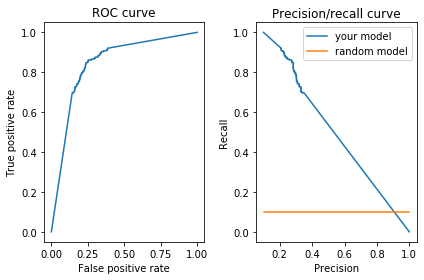

In [169]:
model = torch.load('models/1_')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)

# 1_2 VGG-19
Here we add a classifier on top of VGG-19 with the hope of extracting higher-level lesion features.

In [7]:
model = models.vgg19(pretrained=False)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Linear(in_features, 2)
model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,6]).to(device))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Test Loss: 12592.7018 Acc: 0.8959
True negatives: 1927
False positives: 28
False negatives: 198
True positives: 19
Area under ROC curve: 0.7400285219277051


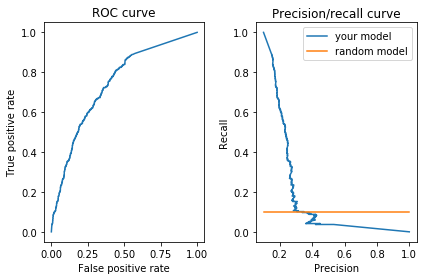

In [27]:
model = torch.load('models/1_2.pt')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)

# 1_3 VGG-19
Here, we switch to the Adam optimizer.

In [15]:
model = models.vgg19(pretrained=False)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Sequential(
                      nn.Linear(in_features, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 2))

model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,7.375]).to(device))
optimizer = optim.Adam(model.parameters())


In [ ]:
train_model(model, criterion, optimizer, num_epochs=25, chunks=9)

Test Loss: 1423.8181 Acc: 0.9001
True negatives: 1955
False positives: 0
False negatives: 217
True positives: 0
Area under ROC curve: 0.5


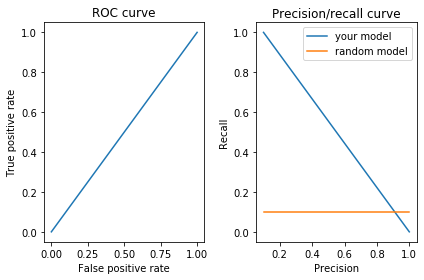

In [28]:
model = torch.load('models/1_3.pt')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)

# 1_4 VGG-19
Instead of adding a classifier on top of VGG-19, here we unfreeze more of its existing layers.

In [21]:
model = models.vgg19(pretrained=False)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Linear(in_features, 2)

model = model.cuda()

criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1,5.5]).to(device))
optimizer = optim.Adam(model.parameters())


In [22]:
for i in range(3,7):
    for parameter in model.classifier[i].parameters():
        parameter.requires_grad = True

In [23]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

139,578,434 total parameters.
16,789,506 training parameters.


Test Loss: 2281.8093 Acc: 0.9001
True negatives: 1955
False positives: 0
False negatives: 217
True positives: 0
Area under ROC curve: 0.724869470930027


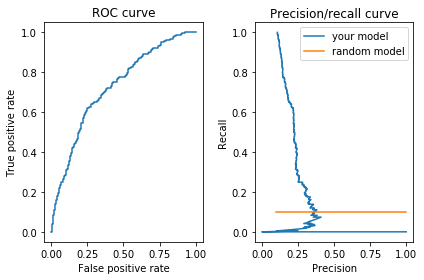

In [29]:
model = torch.load('models/1_4.pt')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)w

In [ ]:
model = models.vgg19(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier[-1].in_features

model.classifier[6] = nn.Linear(in_features, 2)
model = model.cuda()

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.params())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

train_model(model, criterion, optimizer, num_epochs=1, chunks=9, weighted_sampler=True)

## 1.5 Same as 1_1 but pre-trained
Note: this works much better

Test Loss: 27230.3572 Acc: 0.8195
True negatives: 1622
False positives: 333
False negatives: 59
True positives: 158
Area under ROC curve: 0.8421558805850531


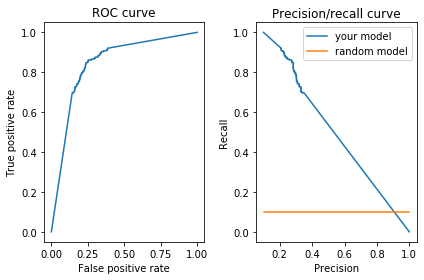

In [6]:
model = torch.load('models/1_5.pt')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)

## 1.6 Densenet w/ Adam, weighted_sampler

In [ ]:
model = models.densenet161(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 2)

model = model.cuda()

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())

train_model(model, criterion, optimizer, num_epochs=25, chunks=9,\
            weighted_sampler=True, data_dir='expanded_data')

torch.save(model, 'models/1_6')

Test Loss: 1225.7247 Acc: 0.8025
True negatives: 1552
False positives: 403
False negatives: 26
True positives: 191
Area under ROC curve: 0.9177955614223248


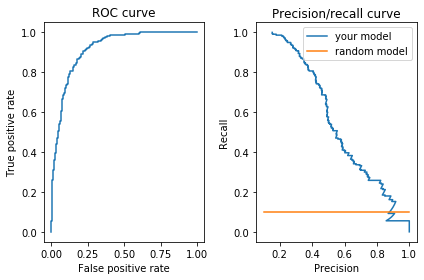

In [8]:
model = torch.load('models/1_6.pt')
all_outputs, all_labels = test_model(model, nn.CrossEntropyLoss())
summarize(all_outputs, all_labels)

## 1.7 Densenet, Adam, unfreeze the last dense block

In [99]:
model = models.densenet161(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 2)

model = model.cuda()

In [100]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

26,476,418 total parameters.
9,491,138 training parameters.


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())

model, train_accs, val_accs = train_model(model, criterion, optimizer, loader_rule='WEIGHTED_SAMPLER',\
            num_epochs=2, chunks=1, data_dir='expanded_data')

Epoch 1/2
----------
Train Loss: 447.9287 Acc: 0.9138
Test Loss: 405.5195 Acc: 0.9249
Epoch 2/2
----------


In [4]:
model = torch.load('models/1_7_70.pt')

# 2. Multiclassifiers
## 2.1 Multiclassifier w/ Densenet, Adam
We begin with a multiclassifier trained like the successful one in section 1.7. There are substantial differences between the data setup for the multiclassifier and the binary classifier; see `preprocessor.ipynb` for details.

In [4]:
def symlink_loader(path):
    return default_loader(os.readlink(path))

description_paths, image_paths, class_dict = get_multiclass_paths('raw_data/Descriptions/',\
                                                          'raw_data/Images')
n = np.sum([class_dict[key] for key in class_dict])
inv_dict = {}
for key in class_dict:
    inv_dict[key] = np.log(n/class_dict[key])

In [5]:
data_dir = 'multiclass_data'
from torchvision.datasets.folder import default_loader

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(300),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(15),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((300,300)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x],
                                          loader=symlink_loader) 
                  for x in ['train', 'val']}

class_names = image_datasets['train'].classes
weights_dict = {class_names.index(name):inv_dict[name] for name in class_names}
weights = [weights_dict[target] for target in image_datasets['train'].targets]
sampler = data_utils.sampler.WeightedRandomSampler(weights, len(image_datasets['train']) ,replacement=True)

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'],\
                                                    batch_size=64,\
                                                    sampler=sampler, num_workers=10),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=64,
                                             shuffle=True, num_workers=10)}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [5]:
model = models.densenet161(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, len(class_names))

model = model.cuda()

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())

In [14]:
model, train_accs, val_accs = train_multiclassifier(model, criterion, optimizer, dataloaders, num_epochs=100) 

Epoch 1/100
----------
train Loss: 3385.8483 Acc: 0.9430
val Loss: 867.0432 Acc: 0.9007
Epoch 2/100
----------
train Loss: 3220.3371 Acc: 0.9457
val Loss: 945.9110 Acc: 0.8922
Epoch 3/100
----------
train Loss: 3277.3296 Acc: 0.9432
val Loss: 892.0308 Acc: 0.8977
Epoch 4/100
----------
train Loss: 3028.7904 Acc: 0.9487
val Loss: 865.5999 Acc: 0.9024
Epoch 5/100
----------
train Loss: 3137.3756 Acc: 0.9469
val Loss: 862.5181 Acc: 0.9011
Epoch 6/100
----------
train Loss: 3090.6198 Acc: 0.9483
val Loss: 958.0362 Acc: 0.9015
Epoch 7/100
----------
train Loss: 2808.8838 Acc: 0.9520
val Loss: 1185.9316 Acc: 0.8683
Epoch 8/100
----------
train Loss: 3027.4138 Acc: 0.9480
val Loss: 863.5774 Acc: 0.9066
Epoch 9/100
----------
train Loss: 2799.1114 Acc: 0.9530
val Loss: 956.9130 Acc: 0.8900
Epoch 10/100
----------
train Loss: 2820.3583 Acc: 0.9518
val Loss: 975.0814 Acc: 0.8956
Epoch 11/100
----------
train Loss: 3000.0001 Acc: 0.9509
val Loss: 917.2226 Acc: 0.9079
Epoch 12/100
----------
train

val Loss: 1124.5663 Acc: 0.9066
Epoch 93/100
----------
train Loss: 1481.8729 Acc: 0.9745
val Loss: 1082.0117 Acc: 0.9182
Epoch 94/100
----------
train Loss: 1450.7011 Acc: 0.9761
val Loss: 1121.5084 Acc: 0.9079
Epoch 95/100
----------
train Loss: 1435.0593 Acc: 0.9769
val Loss: 1232.5734 Acc: 0.9079
Epoch 96/100
----------
train Loss: 1553.7693 Acc: 0.9749
val Loss: 991.2636 Acc: 0.9126
Epoch 97/100
----------
train Loss: 1407.4362 Acc: 0.9768
val Loss: 963.9994 Acc: 0.9207
Epoch 98/100
----------
train Loss: 1353.8247 Acc: 0.9773
val Loss: 996.2701 Acc: 0.9113
Epoch 99/100
----------
train Loss: 1567.1253 Acc: 0.9749
val Loss: 1124.7755 Acc: 0.9020
Epoch 100/100
----------
train Loss: 1371.6650 Acc: 0.9772
val Loss: 1123.8580 Acc: 0.9113
Training complete in 696m 51s
Best val Acc: 0.920716


In [13]:
def train_multiclassifier(model, criterion, optimizer, dataloaders, num_epochs=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        if epoch % 10==0:
            torch.save(model, 'models/2_' + str(epoch) + '.pt')

        for phase in ['train', 'val']:
            if phase=='train':
                model.train()  # Set model to training mode
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # track history
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize
                if phase=='train':
                    loss.backward()
                    optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            loss = running_loss
            acc = running_corrects.double() / len(image_datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, loss, acc))
        
            # deep copy the model
            if phase=='val' and acc > best_acc:
                best_acc = acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase=='val':
                val_accs.append(float(acc))    
            else:
                train_accs.append(float(acc))
                      
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accs, val_accs

In [9]:
model = torch.load('models/2_1_best.pt')
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters())

In [11]:
model.eval()
all_outputs=[]
all_labels=[]
running_loss = 0
running_corrects = 0
for inputs, labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # track history
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        all_outputs.append(outputs)
        all_labels.append(labels)
    # statistics
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

loss = running_loss
acc = running_corrects.double() / len(image_datasets['val'])

In [19]:
all_outputs = torch.cat((*all_outputs,))
all_labels = torch.cat((*all_labels,))
_, all_preds = torch.max(all_outputs, 1)
classes = image_datasets['val'].classes

In [29]:
def multiclass_summary(all_outputs, all_labels, class_dict):
    ''' Print AUC for each class
    '''
    sm = nn.Softmax(dim=1)
    roc_preds = sm(all_outputs).cpu().numpy()
    roc_labels = all_labels.cpu().numpy()

    plt.subplots(figsize=(13,8))
    tprs = []

    for i, lesion_class in enumerate(sorted(list(class_dict.keys()))):
        roc_preds_i = roc_preds[:,i]
        roc_labels_i = (roc_labels==i).astype(int)
        auc = roc_auc_score(roc_labels_i, roc_preds_i)

        fpr, tpr, thresholds = roc_curve(roc_labels_i, roc_preds_i)
        tprs.append(tpr)

        plt.subplot(3,3,i+1)
        plt.plot(fpr, tpr, label='densenet161')
        plt.plot(np.asarray([0.0, 1.0]), np.asarray([0.1, 1.0]), linestyle='dotted', label='random model')
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title("{} (n={})\nAUC: {:.4f}"\
                  .format(lesion_class, str(class_dict[lesion_class]), auc))
        plt.legend(loc='upper right')

    plt.tight_layout()

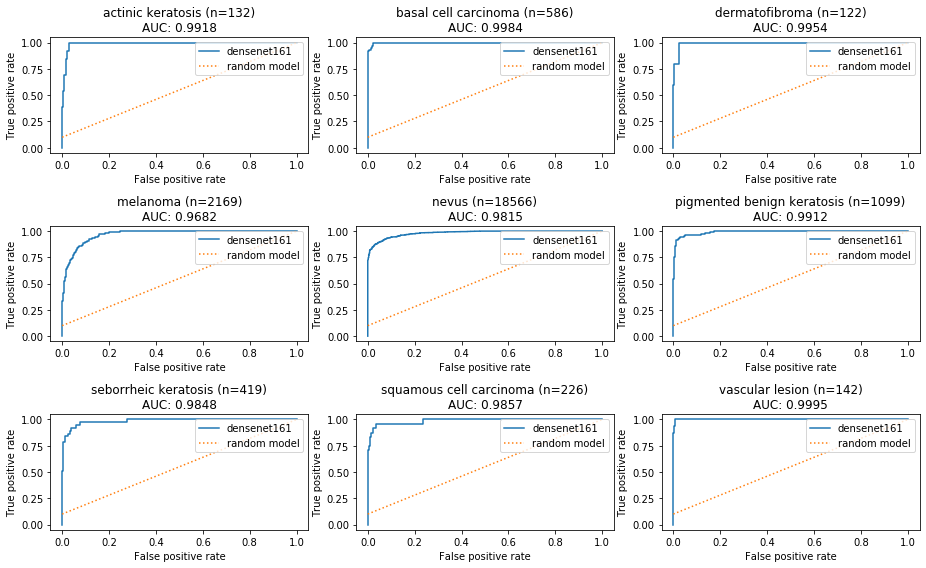

In [73]:
multiclass_summary(all_outputs, all_labels, class_dict)

In [95]:
def balanced_multiclass_accuracy(all_preds, all_labels, classes):
    tprs = []
    for i in range(len(classes)):
        pos = int((all_labels==i).sum())
        true_pos = int(((all_preds==i)*(all_labels==i)).sum())
        tprs.append(true_pos/pos)
        print(true_pos)
        print(pos)
    return sum(tprs)/9.

In [19]:
batch = next(iter(dataloaders['train']))

In [21]:
batch[1]

tensor([0, 8, 0, 1, 5, 6, 6, 5, 2, 3, 3, 3, 6, 4, 4, 8, 5, 0, 4, 3, 5, 4, 4, 4,
        1, 3, 8, 3, 4, 5, 2, 3, 6, 4, 5, 3, 5, 4, 4, 1, 6, 3, 4, 4, 0, 6, 4, 5,
        4, 4, 4, 1, 4, 3, 4, 4, 4, 3, 3, 6, 1, 3, 3, 1])

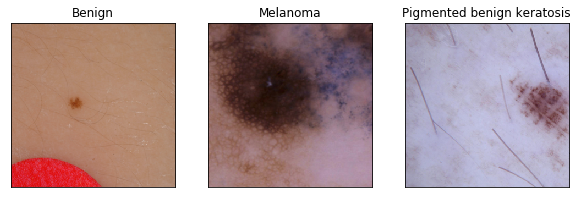

In [30]:
plt.subplots(figsize=(10,10))
plt.subplot(1,3,1)
# benign
plt.imshow(batch[0][-9].cpu().permute(1,2,0).numpy())
plt.xticks([])
plt.yticks([])
plt.title('Benign')

plt.subplot(1,3,2)
# melanoma
plt.imshow(batch[0][-2].cpu().permute(1,2,0).numpy())
plt.xticks([])
plt.yticks([])
plt.title('Melanoma')

# pigmented benign keratosis
plt.subplot(1,3,3)
plt.imshow(batch[0][4].cpu().permute(1,2,0).numpy())
plt.xticks([])
plt.yticks([])
plt.title('Pigmented benign keratosis')

plt.show()